In [1]:
from functions import *
import json
from langid.langid import LanguageIdentifier, model
from collections import Counter
import operator
import random
import os
import langid
import seaborn as sns
import matplotlib.colors as mcolors
#https://towardsdatascience.com/visualizing-topic-models-with-scatterpies-and-t-sne-f21f228f7b02
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document

/home/ruben/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
#import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# NLTK Stop words
from nltk.corpus import stopwords


In [3]:
#base_path = "/media/ruben/Data Drive/react-data/protest/{}".format("carlo-batch-selection")
#base_path = "D:/react-data/protest/{}".format("selection2")
data = pd.read_csv('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/data-full-dd-full.csv')

In [4]:
# Functions
def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    stop_words = stopwords.words('italian')
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def TopicTerms(lda_model,topic):
    tm = dict(lda_model.show_topics(formatted=False,num_words=10))
    ttt = [i[0] for i in tm[topic]]
    return " | ".join(ttt)

In [7]:
dt = dict()

for lan in ['it','en','fr','el','es']:
    
    ss = data[data['language'] == lan]
    identifiers = list(ss['identifier'])
    sentences = list(ss['sentences'])
    sentences = [" ".join(str(s).split('||')) for s in sentences]
    sentences = [s for s in sentences if langid.classify(s)[0] == lan and "carlo" in s or "giuliani" in s]
    print(lan, len(sentences))
    ss = dict(list(zip(identifiers,sentences)))
    dt.update({lan:ss})
    

id2photo = dict()

for c,i in enumerate(data['photo']):
    ss = data[data['photo'] == i]
    id2photo.update({i:list(set(ss['identifier']))})

it 537
en 54
fr 42
el 34
es 96


In [14]:
# # Import Data

# dt = dict()
# id2photo = dict()

# for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
#     photo_folder = os.path.join(base_path, photo)
#     num_iterations = [fol for fol in os.listdir(photo_folder) if os.path.isdir(os.path.join(photo_folder,fol)) and "source" not in fol and "context" not in fol]
#     num_iterations = len(num_iterations)

#     start_iter = 1
#     range_iter = [str(i) for i in list(range(1,num_iterations + 1))]

#     folder_base = os.path.join(base_path,photo,photo)
    
#     if photo not in id2photo.keys():
#         id2photo.update({photo:list()})
    
#     for iteration in range_iter:
#         fn = os.path.join(folder_base + "_" +str(iteration),"txt", "parsed_text.json")
        
#         with open(fn) as fp:
#             pages = json.load(fp)
            
#         for identifier,sentences in pages.items():

#             id2photo[photo].append(identifier)
#             sentences = [s.replace("\n","").lower() for s in sentences]
#             sentences = [re.sub(' +', ' ', s) for s in sentences]
            
#             language = langid.classify(" ".join(sentences))[0]
#             if language not in dt.keys():
#                 dt.update({language:dict()})
            
#             dt[language].update({identifier:" ".join(sentences)})

In [9]:
def LDA(num_topics,language):
    sentences_ids = [[k,v] for k,v in dt[language].items()]
    sentences = [i[1] for i in sentences_ids]
    sentences = list(sent_to_words(sentences))
    stop_words = stopwords.words('italian') + stopwords.words('french')
    sentences = remove_stopwords(sentences)
    id2word = corpora.Dictionary(sentences)
    corpus = [id2word.doc2bow(text) for text in sentences]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=50,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True) #minimum_probability=0.0
    
    refdf = pd.read_csv("/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/descriptive-full.csv")
    refdf = dict(zip(refdf['image'],refdf['pretty_title']))
    
    # Create Dataframe as presented in:
    # https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/#topic=0&lambda=1&term=
    df= []

    for c,bow in enumerate(corpus):
        index_pos = c
        doc_text = sentences[c]
        
        photo = [k for k,v in id2photo.items() if sentences_ids[c][0] in v][0]
        
        if len(doc_text) == 0:
            continue
        
        for topic_id,prob in lda_model.get_document_topics(bow):
            df.append([index_pos, topic_id, prob, TopicTerms(lda_model,topic_id), sentences_ids[c][0], photo])

    df = pd.DataFrame(df,columns=['index_pos', 'topic_id', 'norm_topic_weights', 'topic_words', 'text_id', 'photo'])
    return lda_model,df

# def PlotCumulative(lda_model,df,num_topics):
#     n_dict = {i[1]:len(df[df['photo'] == i[1]]) for i in list(zip(df['text_id'],df['photo']))}
#     dfa = df[['topic_words','photo','norm_topic_weights']].groupby(['topic_words','photo']).sum().reset_index()
#     dfa = dfa.pivot(index='photo',columns='topic_words',values='norm_topic_weights').reset_index()
#     p = dfa.plot.barh(x='photo',stacked=True,figsize = (20,15),colormap='viridis',width=0.8)
#     fig = p.get_figure()
#     fig.savefig("/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/topic-document-dist-{}-cumulative-a.png".format(num_topics),dpi=300)
    
# def PlotNormalized(lda_model,df,num_topics):
#     df2 = pd.DataFrame()

#     for ph in list(set(df['photo'])):
#         tmp = df[df['photo'] == ph][['topic_words','norm_topic_weights']].groupby('topic_words').sum().sort_values('topic_words').reset_index()
#         sum_ = tmp['norm_topic_weights'].sum()
#         tmp['norm_topic_weights'] = tmp['norm_topic_weights'] / sum_ * 100
#         tmp['photo'] = ph
#         df2 = df2.append(tmp)
#     df2 = df2.pivot(index="photo",columns='topic_words',values="norm_topic_weights").reset_index()
#     df2 = df2.sort_values(list(df2.columns)[1],ascending=True)
#     p = df2.plot.barh(x='photo',stacked=True,figsize = (15,15),colormap='viridis',width=0.8)
#     plt.legend(list(df2.columns)[1:], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=15)
#     plt.xticks(fontsize=16)
#     plt.yticks(fontsize=16)
#     fig = p.get_figure()
#     fig.savefig("/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/topic-document-dist-{}-normalized-a.png".format(num_topics),
#                dpi=300,
#                bbox_inches='tight')
    
def PlotWords(lda_model,df,num_topics,figsize_width,figsize_height,columns,rows):
    ## Top words

    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in sentences for w in w_list]
    counter = Counter(data_flat)
    out = []

    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(columns, rows, figsize=(figsize_width,figsize_height), sharey=True, dpi=300)

    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
#         ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
#         ax_twin = ax.twinx()
#         ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
#         ax.set_ylabel('Word Count', color=cols[i])
        #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 10000)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        print(i," ".join(list(df.loc[df.topic_id==i, 'word'])))
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right',fontsize=22)
        ax.legend(loc='upper left')#; ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.savefig('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/topics-{}-{}-words-onlycarlo.png'.format('italian',num_topics),dpi=500)
    #plt.show()

model with 2 topics trained
0 de que en chiesa el giuliani carlo et por die
1 the of to and giuliani carlo had piu that stato
model with 4 topics trained
0 pd piu urbisaglia consigliere anni comunale giuliani vita poi carlo
1 the of to and had that been on by was
2 giuliani carlo piu stato genova anni polizia dopo due piazza
3 de que it en alpinestudio el dailyhttps por giuliani et
model with 6 topics trained
0 chiesa san grande secolo papa maria roma stile cattedrale santa
1 the of to and had that been on by was
2 giuliani piu carlo stato genova anni polizia dopo perche essere
3 de que en el por giuliani et les carlo los
4 der die und von den wurde auf bobbio carlo das
5 it alpinestudio dailyhttps home html large_default medium_default img alpino alpinismo
model with 8 topics trained
0 και του που την το της απο με να τον
1 aloi memoriale colonnelli ilariaalpi sid intelisano sharealike tunzi creative attribution
2 anni chiesa polizia due san roma secolo de maria diaz
3 de que en el et

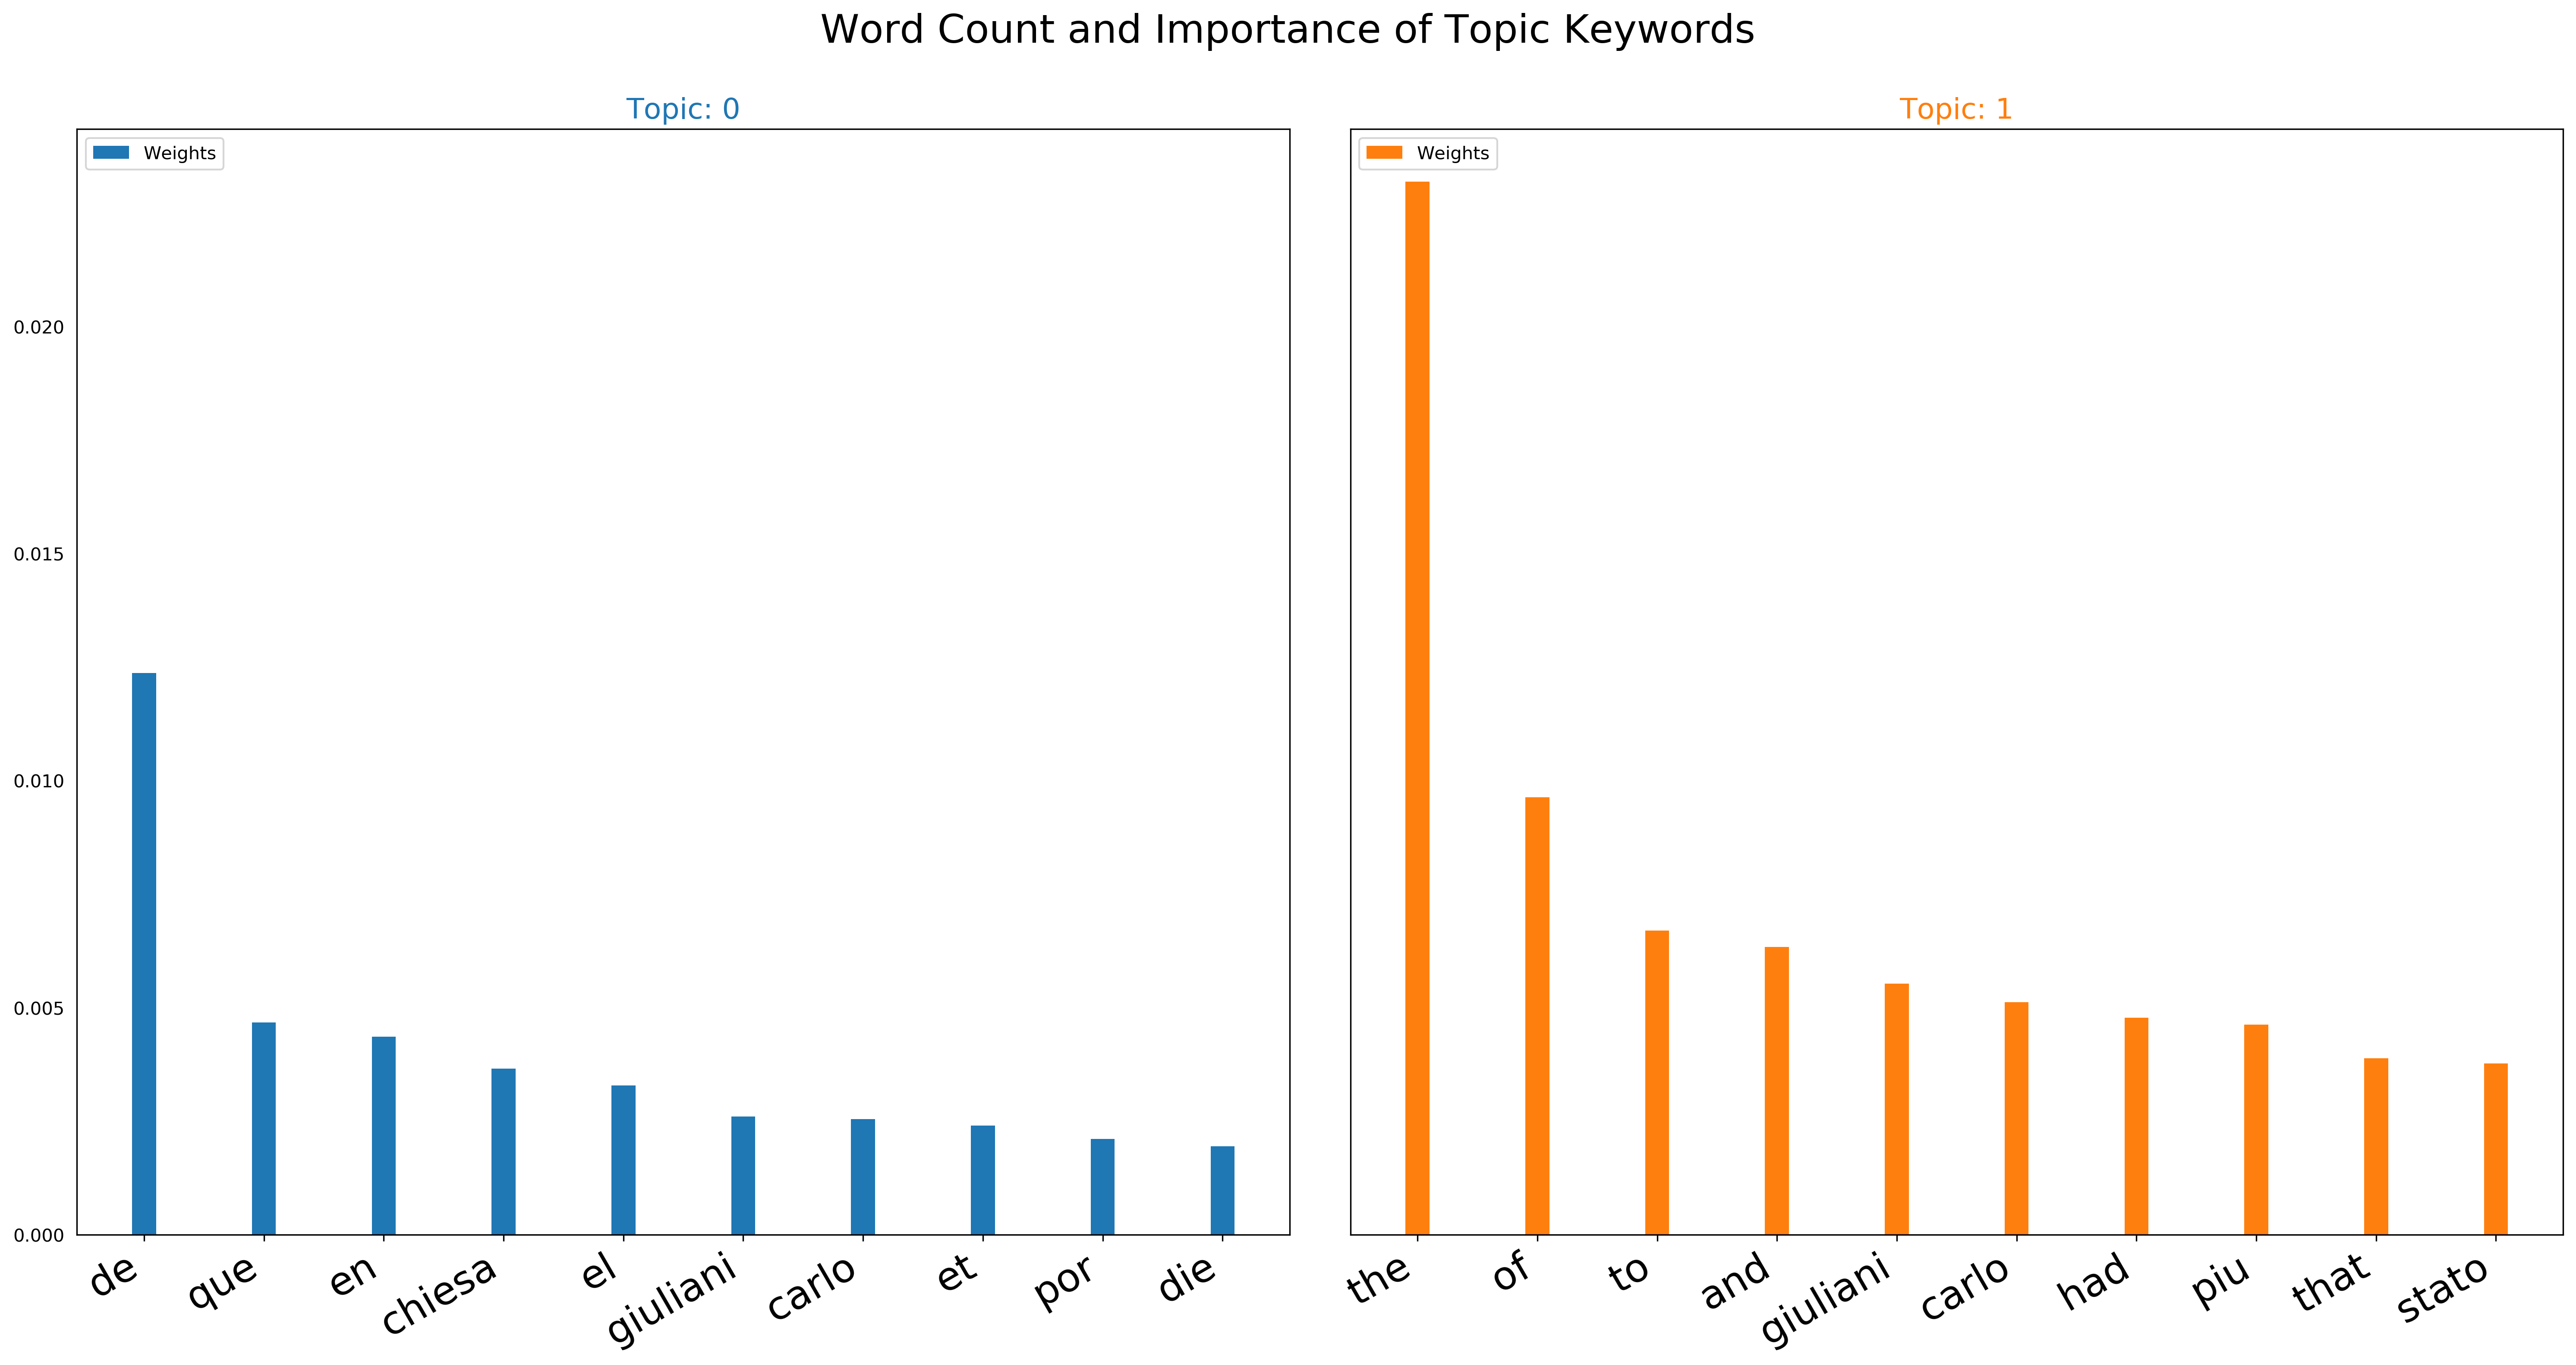

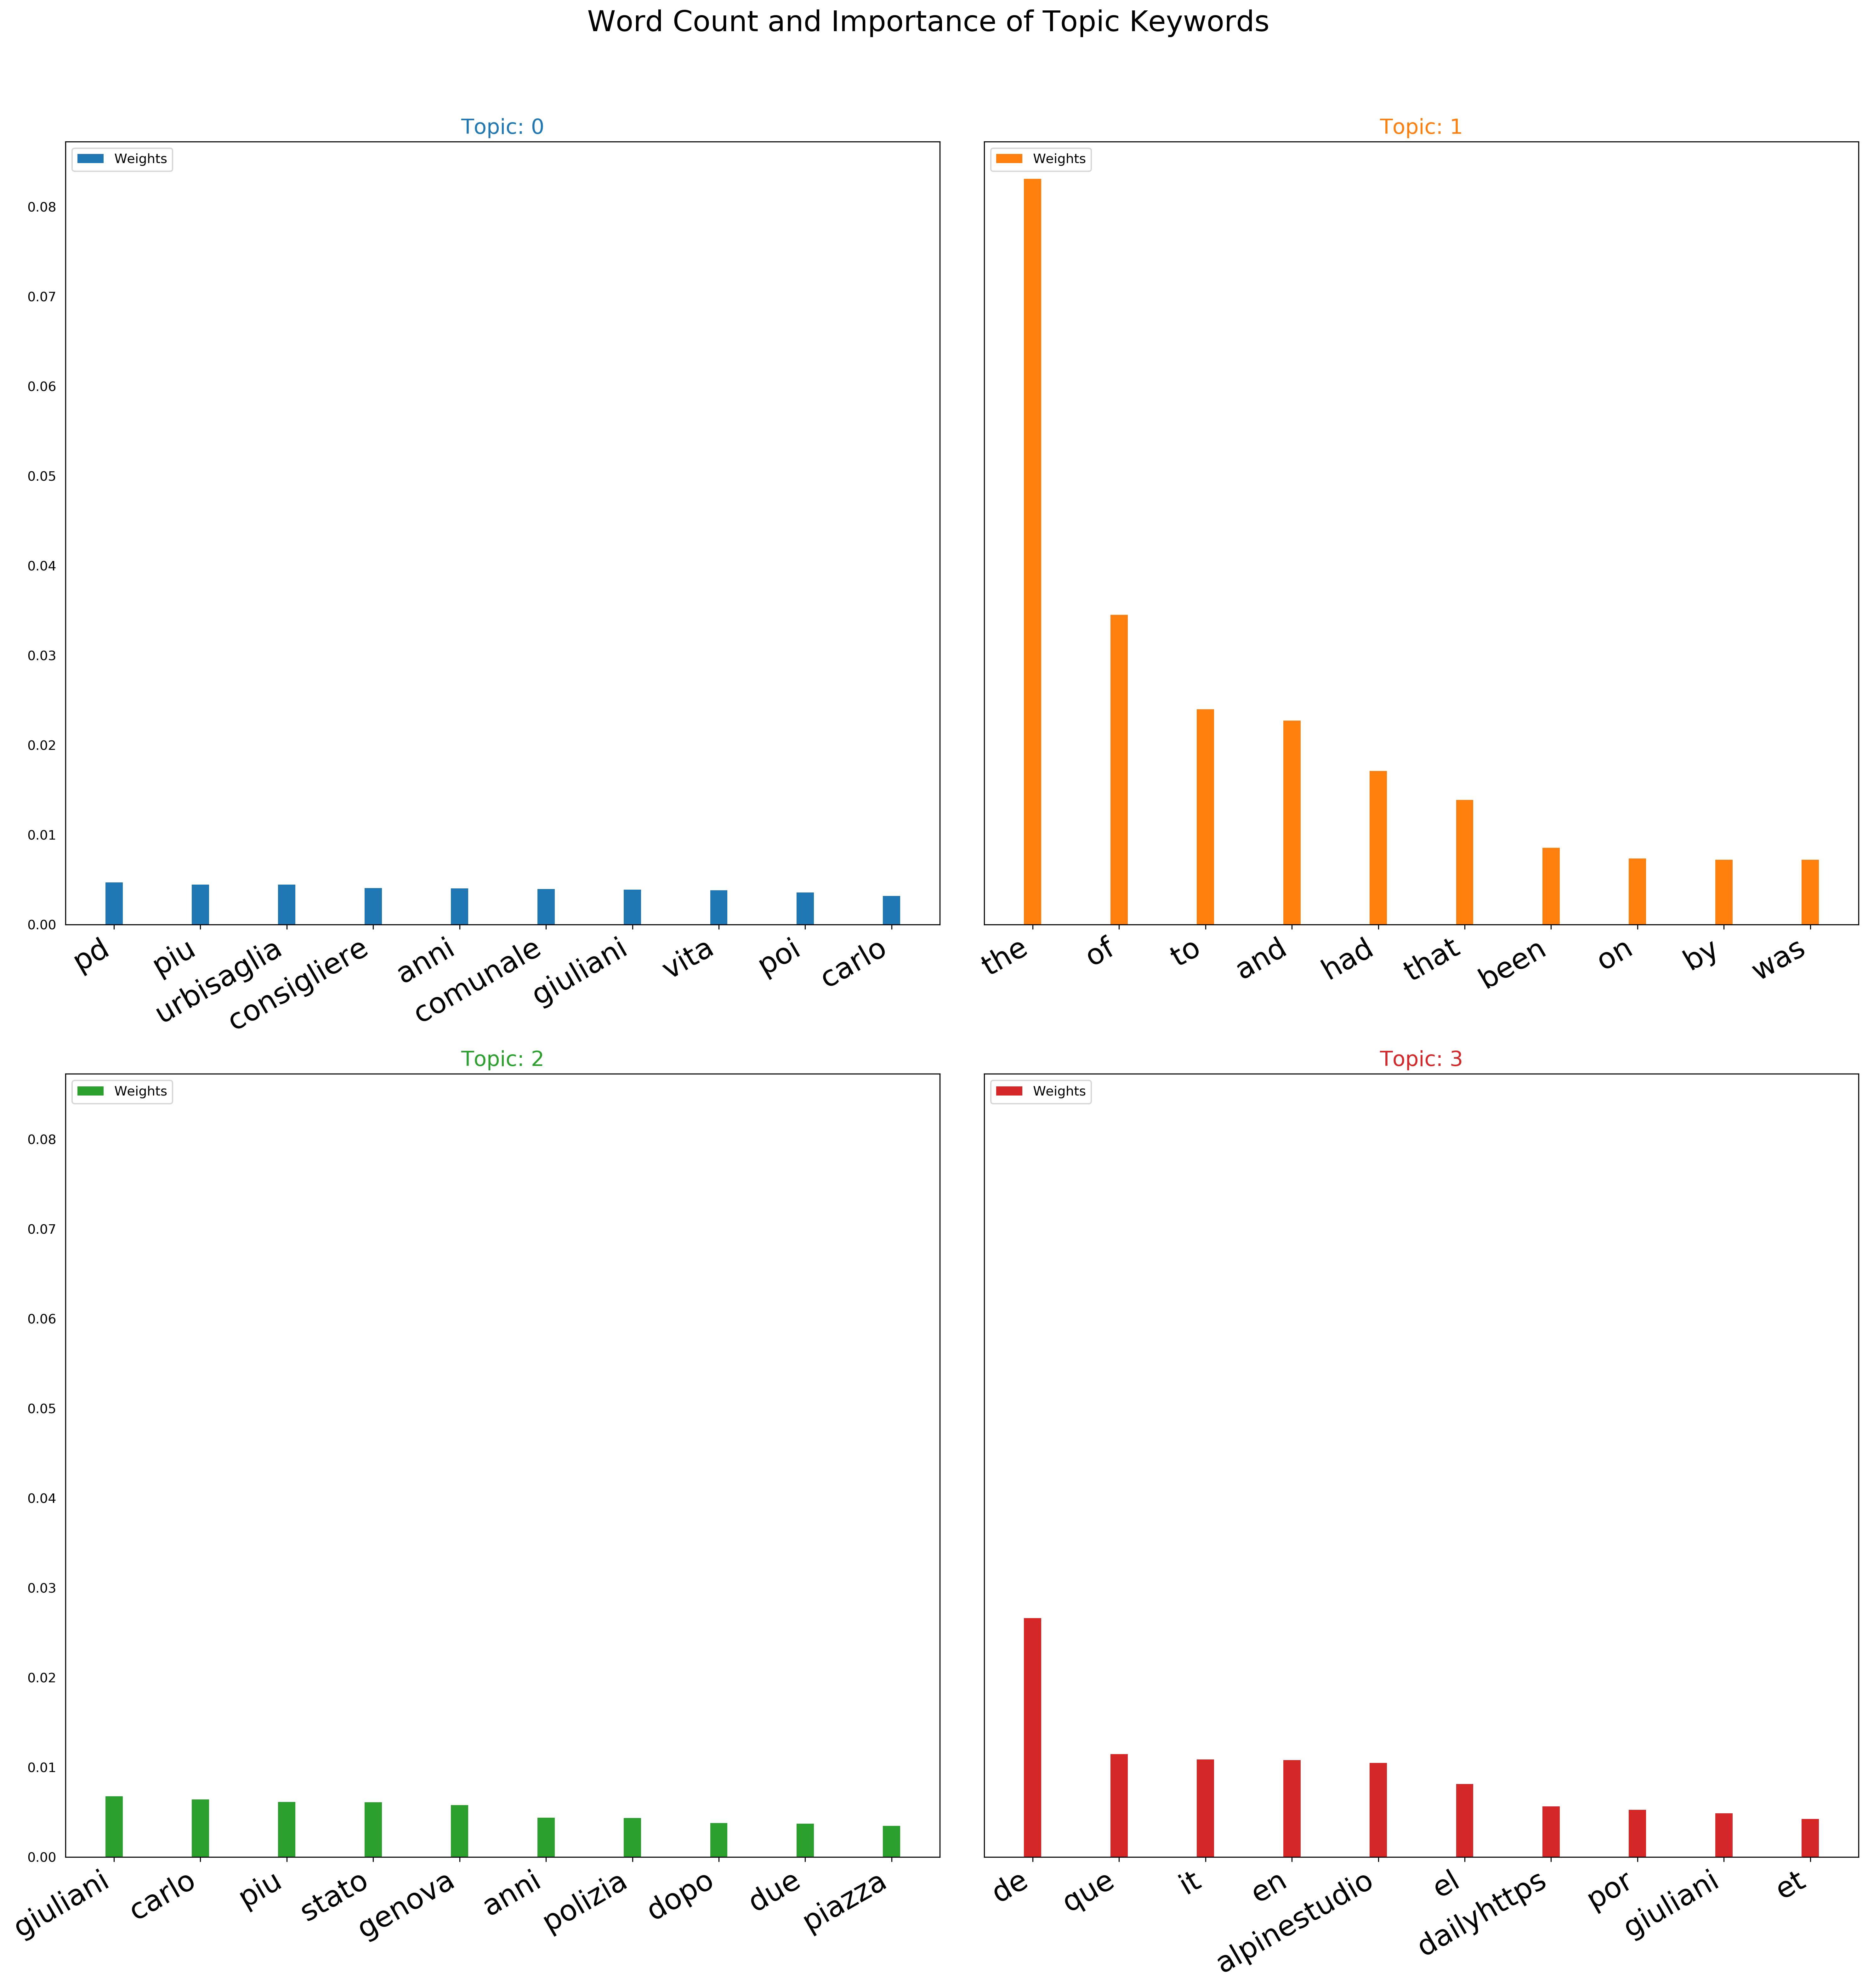

In [10]:
wh = {2:[1,2,20,10],
          4:[2,2,20,20],
          6:[2,3,30,20],
          8:[2,4,40,20],
          10:[2,5,50,20]}

for i in range(2,11,2):
    num_topics = i
    lda_model,df = LDA(num_topics,'it')
    print('model with {} topics trained'.format(i))
    rows = wh[i][1]
    columns = wh[i][0]
    figsize_width = wh[i][2]
    figsize_height = wh[i][3]
    PlotWords(lda_model,df,num_topics,figsize_width,figsize_height,columns,rows)